# Нейросетевая классификация текстов

Решим задачу классификации текстов. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [2]:
# pip install datasets

In [5]:
# pip install nltk

Импорт необходимых библиотек

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import gc

import seaborn
seaborn.set(palette='summer')

In [60]:
nltk.download('punkt')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Загрузим датасет. 

In [10]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [11]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [12]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [13]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Наша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которая нам покажет скор для обученной модели.

In [14]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Наше исследование будет состоять из двух частей:

### Запуск базовой модели
Обучим ее и вычислим `score`, который затем можно будет использовать в качестве бейзлайна. 

### Проведение экспериментов по улучшению модели
Чтобы улучшить качество базовой модели, попробуем различные идеи экспериментов.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуем другие нейросетевые модели --- LSTM и GRU. Мы возьмем [GRU]
* (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы используем как базовую.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

### Запуск базовой модели

In [15]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [20]:
def clear_vram():
    gc.collect()
    torch.cuda.empty_cache()

In [21]:
clear_vram()

In [18]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [19]:
model

CharLM(
  (embedding): Embedding(11842, 256)
  (rnn): RNN(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [22]:
clear_vram()

In [23]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

#### Отрисуем график loss

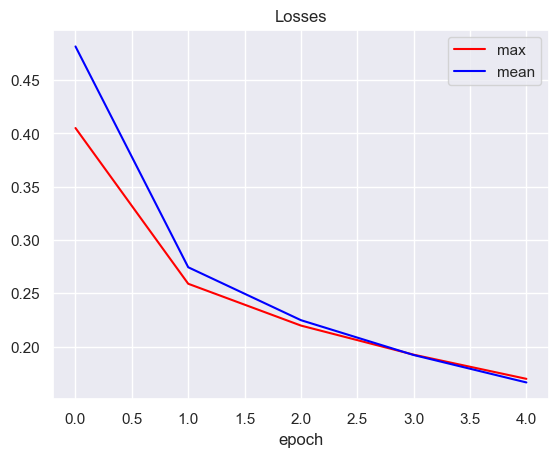

In [25]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 91.52
Лучшая accuracy для подхода mean: 90.62


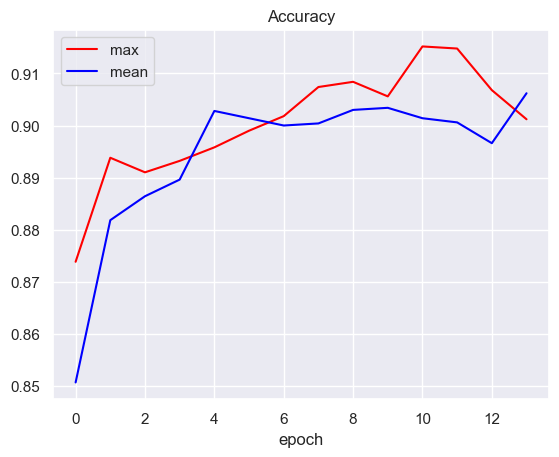

In [27]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [28]:
torch.save(model.state_dict(), 'model_CharLM.pth')

In [29]:
del model

### Проведение экспериментов по улучшению модели

### Попробуем модель GRU

In [30]:
class CharGRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [31]:
clear_vram()

In [32]:
model = CharGRU(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [33]:
model

CharGRU(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [34]:
clear_vram()

In [35]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharGRU(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

#### Отрисуем график loss

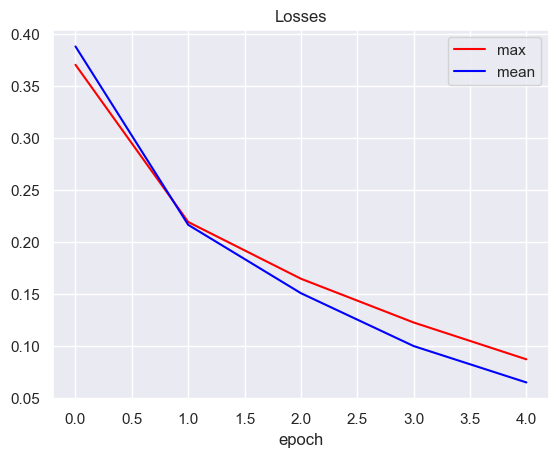

In [36]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 91.68
Лучшая accuracy для подхода mean: 91.26


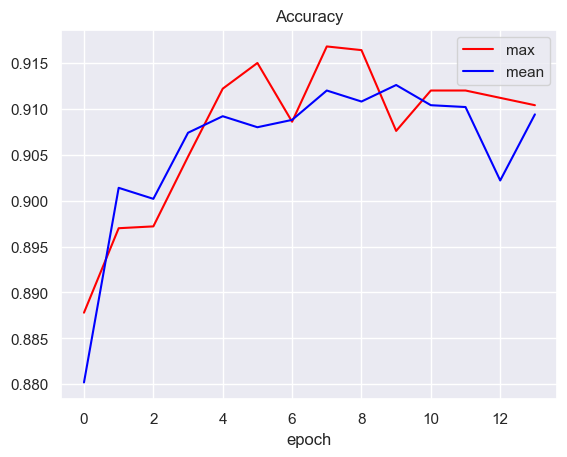

In [37]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [38]:
torch.save(model.state_dict(), 'model_CharGRU.pth')

In [39]:
del model

### Попробуем модель GRU c num_layers=2

In [40]:
class CharGRUx2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [41]:
clear_vram()

In [42]:
model = CharGRUx2(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [43]:
model

CharGRUx2(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [44]:
clear_vram()

In [45]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharGRUx2(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

#### Отрисуем график loss

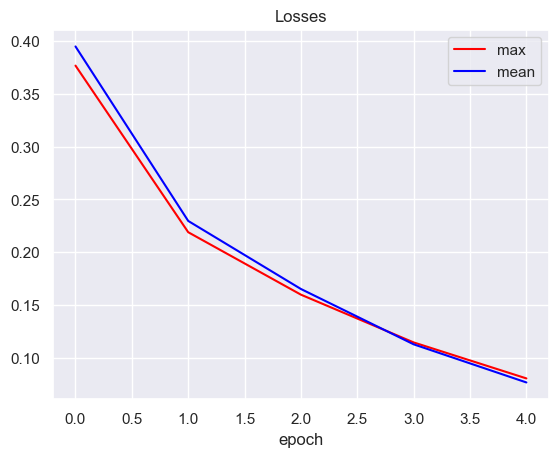

In [46]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 91.54
Лучшая accuracy для подхода mean: 91.38


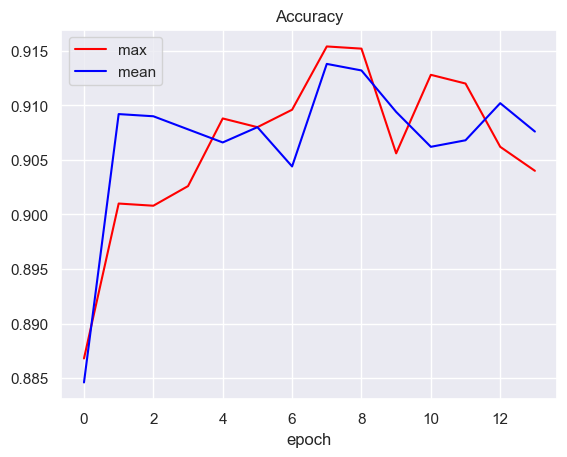

In [47]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [48]:
torch.save(model.state_dict(), 'model_CharGRUx2.pth')

In [49]:
del model

### Попробуем модель RNN c num_layers=2 и 5 эпох

In [50]:
class CharLMx2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [51]:
clear_vram()

In [52]:
model = CharLMx2(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [53]:
model

CharLMx2(
  (embedding): Embedding(11842, 256)
  (rnn): RNN(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [54]:
clear_vram()

In [55]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLMx2(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

#### Отрисуем график loss

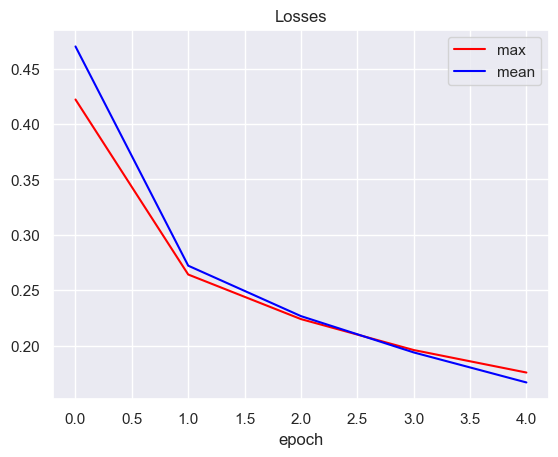

In [56]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Отрисуем график Accuracy

Лучшая accuracy для подхода max: 90.76
Лучшая accuracy для подхода mean: 90.98


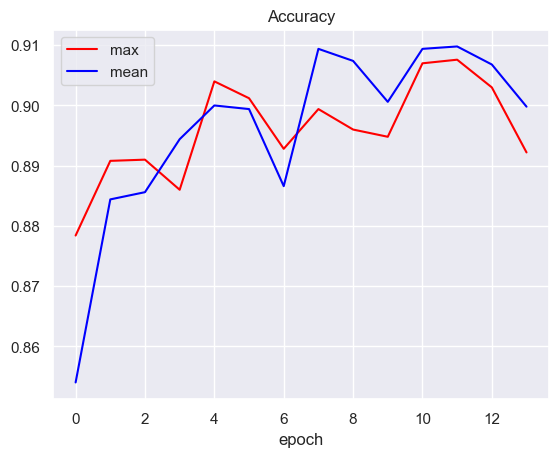

In [57]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [58]:
torch.save(model.state_dict(), 'model_CharLMx2.pth')

In [59]:
del model

### Лучшая модель показала качество скора в 91,68 на max

### Подитожим:
Базовая модель идет стабильно к увеличению скора, но до опредленного предела, максимальный скор 91,52 на max
Модель GRU c максимальным скором 91,68 на max
Модель GRU с двумя слоями дала скор в 91.54 на max
Модель RNN с 2-мя слоями дала скор 90.98 на mean

Базовая модель показала большую стабильность, но модели GRU дает неплохие резуотиаие в скоре.

Оптимальная модель с моей точки зрения - GRU